## 📦 Step 1: Importar Librerías

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.interpolate import interp1d
from pathlib import Path
import random
from tqdm import tqdm
import json

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## ⚙️ Step 2: Configuración

In [12]:
# ============================================
# CONFIGURACIÓN
# ============================================

# Rutas
AUDIO_DIR = Path("../../VCTK-Corpus/VCTK/Dataset_2Seg")
OUTPUT_DIR = Path("../data")

# Parámetros de segmentación
SEGMENT_SIZE = 5000      # Muestras por segmento (alta resolución)
INPUT_SIZE = 1000        # Tamaño de entrada al modelo (baja resolución)
DOWNSAMPLE_FACTOR = SEGMENT_SIZE // INPUT_SIZE  # Factor 5x

# Parámetros del dataset
# NOTA: Usamos 500 train para comparabilidad con ECG
#       Test será 20% del total → 125 segmentos
TRAIN_SAMPLES = 500      # Número de segmentos para entrenamiento
TEST_SAMPLES = 125       # Número de segmentos para test
TOTAL_SEGMENTS = TRAIN_SAMPLES + TEST_SAMPLES  # = 625 total
RANDOM_SEED = 42

# Verificar rutas
print("="*60)
print("CONFIGURACIÓN")
print("="*60)
print(f"📂 Directorio de audio: {AUDIO_DIR}")
print(f"📂 Audio existe: {AUDIO_DIR.exists()}")
print(f"💾 Directorio de salida: {OUTPUT_DIR}")
print(f"\n--- Parámetros ---")
print(f"📊 Segment size (high-res): {SEGMENT_SIZE} muestras")
print(f"📊 Input size (low-res): {INPUT_SIZE} muestras")
print(f"⬇️  Factor de downsampling: {DOWNSAMPLE_FACTOR}x")
print(f"\n--- Split Train/Test ---")
print(f"🎯 Segmentos de entrenamiento: {TRAIN_SAMPLES} ({100*TRAIN_SAMPLES/TOTAL_SEGMENTS:.0f}%)")
print(f"🎯 Segmentos de test: {TEST_SAMPLES} ({100*TEST_SAMPLES/TOTAL_SEGMENTS:.0f}%)")
print(f"🎯 Total segmentos: {TOTAL_SEGMENTS}")
print("="*60)

# Listar archivos
audio_files = sorted([f for f in AUDIO_DIR.glob("*.wav")])
print(f"\n📁 Total de archivos WAV: {len(audio_files)}")

CONFIGURACIÓN
📂 Directorio de audio: ../../VCTK-Corpus/VCTK/Dataset_2Seg
📂 Audio existe: True
💾 Directorio de salida: ../data

--- Parámetros ---
📊 Segment size (high-res): 5000 muestras
📊 Input size (low-res): 1000 muestras
⬇️  Factor de downsampling: 5x

--- Split Train/Test ---
🎯 Segmentos de entrenamiento: 500 (80%)
🎯 Segmentos de test: 125 (20%)
🎯 Total segmentos: 625

📁 Total de archivos WAV: 2411


## 🔧 Step 3: Funciones de Procesamiento

In [13]:
def load_audio(filepath):
    """Carga un archivo de audio WAV."""
    y, sr = librosa.load(filepath, sr=None)
    return y, sr


def extract_random_segment(audio, segment_size):
    """
    Extrae un segmento aleatorio de tamaño fijo del audio.
    
    Args:
        audio: señal de audio completa
        segment_size: número de muestras a extraer
    
    Returns:
        segment: segmento de audio
        start_idx: índice de inicio
    """
    if len(audio) <= segment_size:
        return None, None
    
    max_start = len(audio) - segment_size
    start_idx = random.randint(0, max_start)
    segment = audio[start_idx:start_idx + segment_size]
    
    return segment, start_idx


def downsample_direct(segment, target_samples):
    """
    Realiza downsampling DIRECTO usando interpolación lineal.
    SIN filtro anti-aliasing (igual que V02).
    
    Args:
        segment: señal de entrada (alta resolución)
        target_samples: número de muestras objetivo (baja resolución)
    
    Returns:
        downsampled: señal de baja resolución
    """
    x_original = np.linspace(0, 1, len(segment))
    x_target = np.linspace(0, 1, target_samples)
    interpolator = interp1d(x_original, segment, kind='linear')
    downsampled = interpolator(x_target)
    return downsampled


print("✅ Funciones definidas:")
print("   - load_audio()")
print("   - extract_random_segment()")
print("   - downsample_direct()")

✅ Funciones definidas:
   - load_audio()
   - extract_random_segment()
   - downsample_direct()


## 📥 Step 4: Extraer Segmentos de Audio

In [14]:
# Fijar semilla para reproducibilidad
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Estructuras para almacenar datos
segments_high = []  # Segmentos de alta resolución (5000)
segments_low = []   # Segmentos de baja resolución (1000)
metadata = []       # Información de cada segmento

# Primero, verificar qué archivos son válidos (suficientemente largos)
valid_files = []
for audio_file in tqdm(audio_files, desc="Verificando archivos"):
    try:
        audio, sr = load_audio(audio_file)
        if len(audio) >= SEGMENT_SIZE:
            # Calcular cuántos segmentos NO solapados caben
            max_segments = len(audio) // SEGMENT_SIZE
            valid_files.append((audio_file, len(audio), sr, max_segments))
    except Exception as e:
        continue

print(f"\n📊 Archivos válidos (>= {SEGMENT_SIZE} muestras): {len(valid_files)} de {len(audio_files)}")

# Calcular cuántos segmentos extraer por archivo
total_capacity = sum(f[3] for f in valid_files)
print(f"📊 Capacidad total de segmentos: {total_capacity}")

# Mezclar archivos válidos para diversidad
random.shuffle(valid_files)

# Extraer segmentos
print(f"\n🎯 Extrayendo {TOTAL_SEGMENTS} segmentos...")

for audio_file, audio_len, sr, max_segs in tqdm(valid_files, desc="Extrayendo segmentos"):
    if len(segments_high) >= TOTAL_SEGMENTS:
        break
    
    # Cargar audio
    audio, _ = load_audio(audio_file)
    
    # Extraer hasta 3 segmentos aleatorios por archivo (para diversidad)
    n_to_extract = min(3, max_segs, TOTAL_SEGMENTS - len(segments_high))
    
    for _ in range(n_to_extract):
        segment_high, start_idx = extract_random_segment(audio, SEGMENT_SIZE)
        
        if segment_high is not None:
            # Degradar: downsample directo (sin anti-aliasing)
            segment_low = downsample_direct(segment_high, INPUT_SIZE)
            
            # Almacenar
            segments_high.append(segment_high)
            segments_low.append(segment_low)
            metadata.append({
                'file': audio_file.name,
                'start_idx': int(start_idx),
                'sr': int(sr)
            })
        
        if len(segments_high) >= TOTAL_SEGMENTS:
            break

# Convertir a arrays numpy
segments_high = np.array(segments_high)
segments_low = np.array(segments_low)

print(f"\n✅ Segmentos extraídos:")
print(f"   Alta resolución: {segments_high.shape}")
print(f"   Baja resolución: {segments_low.shape}")
print(f"   Archivos usados: {len(set(m['file'] for m in metadata))}")

Verificando archivos: 100%|██████████| 2411/2411 [00:01<00:00, 1360.62it/s]



📊 Archivos válidos (>= 5000 muestras): 2411 de 2411
📊 Capacidad total de segmentos: 45809

🎯 Extrayendo 625 segmentos...


Extrayendo segmentos:   9%|▊         | 209/2411 [00:00<00:01, 1799.10it/s]


✅ Segmentos extraídos:
   Alta resolución: (625, 5000)
   Baja resolución: (625, 1000)
   Archivos usados: 209


## 📊 Step 5: Visualizar Muestras

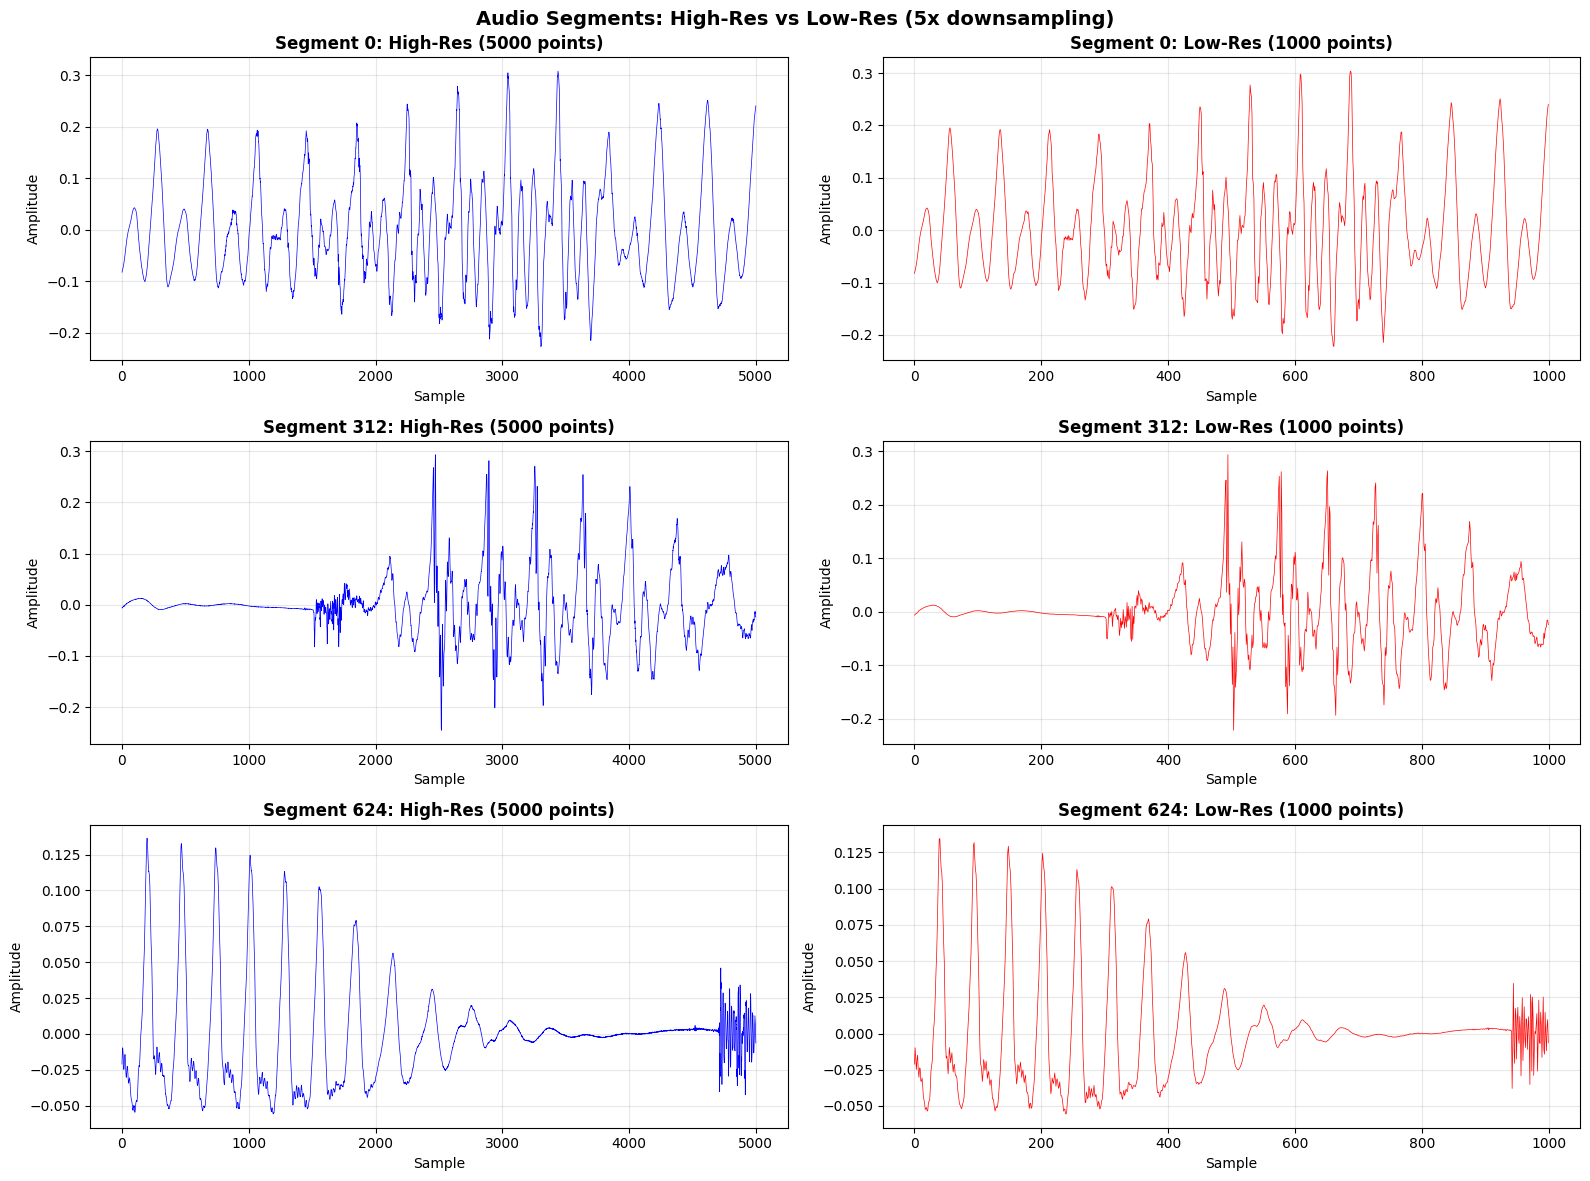


📊 Estadísticas de los segmentos:
   High-res - Min: -0.9974, Max: 0.8831
   High-res - Mean: 0.0001, Std: 0.0674
   Low-res - Min: -0.9909, Max: 0.8501
   Low-res - Mean: 0.0001, Std: 0.0672


In [15]:
# Visualizar algunos ejemplos
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

sample_indices = [0, len(segments_high)//2, len(segments_high)-1]

for row, idx in enumerate(sample_indices):
    # Alta resolución
    axes[row, 0].plot(segments_high[idx], color='blue', linewidth=0.5)
    axes[row, 0].set_title(f'Segment {idx}: High-Res (5000 points)', fontweight='bold')
    axes[row, 0].set_xlabel('Sample')
    axes[row, 0].set_ylabel('Amplitude')
    axes[row, 0].grid(True, alpha=0.3)
    
    # Baja resolución
    axes[row, 1].plot(segments_low[idx], color='red', linewidth=0.5)
    axes[row, 1].set_title(f'Segment {idx}: Low-Res (1000 points)', fontweight='bold')
    axes[row, 1].set_xlabel('Sample')
    axes[row, 1].set_ylabel('Amplitude')
    axes[row, 1].grid(True, alpha=0.3)

plt.suptitle('Audio Segments: High-Res vs Low-Res (5x downsampling)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas
print("\n📊 Estadísticas de los segmentos:")
print(f"   High-res - Min: {segments_high.min():.4f}, Max: {segments_high.max():.4f}")
print(f"   High-res - Mean: {segments_high.mean():.4f}, Std: {segments_high.std():.4f}")
print(f"   Low-res - Min: {segments_low.min():.4f}, Max: {segments_low.max():.4f}")
print(f"   Low-res - Mean: {segments_low.mean():.4f}, Std: {segments_low.std():.4f}")

## ✂️ Step 6: Dividir en Train/Test

In [16]:
# Crear índices aleatorios para partición
all_indices = np.arange(len(segments_high))
np.random.shuffle(all_indices)

# Separar índices de entrenamiento y test
train_indices = all_indices[:TRAIN_SAMPLES]
test_indices = all_indices[TRAIN_SAMPLES:TRAIN_SAMPLES + TEST_SAMPLES]

# Crear datasets
x_train = segments_low[train_indices]   # Entrada: baja resolución
y_train = segments_high[train_indices]  # Salida: alta resolución

x_test = segments_low[test_indices]
y_test = segments_high[test_indices]

print("="*60)
print("PARTICIÓN DE DATOS")
print("="*60)
print(f"📊 Entrenamiento: {len(train_indices)} segmentos ({100*len(train_indices)/TOTAL_SEGMENTS:.0f}%)")
print(f"   x_train (low-res): {x_train.shape}")
print(f"   y_train (high-res): {y_train.shape}")
print(f"\n📊 Test: {len(test_indices)} segmentos ({100*len(test_indices)/TOTAL_SEGMENTS:.0f}%)")
print(f"   x_test (low-res): {x_test.shape}")
print(f"   y_test (high-res): {y_test.shape}")
print("="*60)

PARTICIÓN DE DATOS
📊 Entrenamiento: 500 segmentos (80%)
   x_train (low-res): (500, 1000)
   y_train (high-res): (500, 5000)

📊 Test: 125 segmentos (20%)
   x_test (low-res): (125, 1000)
   y_test (high-res): (125, 5000)


## 💾 Step 7: Guardar Datos

In [17]:
# Crear directorios si no existen
segments_dir = OUTPUT_DIR / "audio_segments"
training_dir = OUTPUT_DIR / "training"
indices_dir = OUTPUT_DIR / "indices"

segments_dir.mkdir(parents=True, exist_ok=True)
training_dir.mkdir(parents=True, exist_ok=True)
indices_dir.mkdir(parents=True, exist_ok=True)

# Guardar todos los segmentos
np.savetxt(segments_dir / "audio_high_5000.txt", segments_high)
np.savetxt(segments_dir / "audio_low_1000.txt", segments_low)
print(f"✅ Segmentos guardados en {segments_dir}/")

# Guardar datos de entrenamiento
np.savetxt(training_dir / "x_audio_train.txt", x_train)
np.savetxt(training_dir / "y_audio_train.txt", y_train)
np.savetxt(training_dir / "x_audio_test.txt", x_test)
np.savetxt(training_dir / "y_audio_test.txt", y_test)
print(f"✅ Datos de entrenamiento guardados en {training_dir}/")

# Guardar índices
np.savetxt(indices_dir / "train_indices_audio.txt", train_indices, fmt='%d')
np.savetxt(indices_dir / "test_indices_audio.txt", test_indices, fmt='%d')
print(f"✅ Índices guardados en {indices_dir}/")

# Guardar metadata como JSON
with open(indices_dir / "metadata_audio.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata guardada")

✅ Segmentos guardados en ../data/audio_segments/
✅ Datos de entrenamiento guardados en ../data/training/
✅ Índices guardados en ../data/indices/
✅ Metadata guardada


## 📊 Step 8: Resumen Final

In [18]:
print("="*70)
print("📋 RESUMEN DE DATOS PREPARADOS")
print("="*70)
print(f"\n📁 Archivos creados:")
print(f"   {segments_dir}/")
print(f"      - audio_high_5000.txt  ({segments_high.shape[0]} × {segments_high.shape[1]})")
print(f"      - audio_low_1000.txt   ({segments_low.shape[0]} × {segments_low.shape[1]})")
print(f"\n   {training_dir}/")
print(f"      - x_audio_train.txt    ({x_train.shape[0]} × {x_train.shape[1]}) - INPUT")
print(f"      - y_audio_train.txt    ({y_train.shape[0]} × {y_train.shape[1]}) - TARGET")
print(f"      - x_audio_test.txt     ({x_test.shape[0]} × {x_test.shape[1]}) - INPUT")
print(f"      - y_audio_test.txt     ({y_test.shape[0]} × {y_test.shape[1]}) - TARGET")
print(f"\n   {indices_dir}/")
print(f"      - train_indices_audio.txt  ({len(train_indices)} índices)")
print(f"      - test_indices_audio.txt   ({len(test_indices)} índices)")
print(f"      - metadata_audio.json")
print("\n" + "="*70)
print("✅ DATOS LISTOS PARA ENTRENAMIENTO")
print("="*70)

📋 RESUMEN DE DATOS PREPARADOS

📁 Archivos creados:
   ../data/audio_segments/
      - audio_high_5000.txt  (625 × 5000)
      - audio_low_1000.txt   (625 × 1000)

   ../data/training/
      - x_audio_train.txt    (500 × 1000) - INPUT
      - y_audio_train.txt    (500 × 5000) - TARGET
      - x_audio_test.txt     (125 × 1000) - INPUT
      - y_audio_test.txt     (125 × 5000) - TARGET

   ../data/indices/
      - train_indices_audio.txt  (500 índices)
      - test_indices_audio.txt   (125 índices)
      - metadata_audio.json

✅ DATOS LISTOS PARA ENTRENAMIENTO
